## Comprensión de lenguaje natural para sinopsis

### Introducción

En este *notebook* vamos a probar diversas técnicas de NLP para transformar una sinopsis de un libro en un vector que sirva de input para nuestro posterior modelo del sistema de recomendación. Trataremos de interpretar qué significado tienen esos vectores o cuáles han sido las técnicas utilizadas para darles esa forma.

Antes de empezar, instalaremos las librerías necesarias para las tareas a realizar. Se recomienda instalar en un entorno de ejecución no local, con GPU disponible. En nuestro caso, lo haremos con [*Google Colab*](https://colab.research.google.com).

In [1]:
%%capture
!pip3 install seaborn
!pip3 install -U spacy
!python3 -m spacy download en_core_web_lg
!pip3 install -U transformers
!pip3 install -U sentence-transformers

### Word embeddings y spaCy

Usaremos, en principio, la librería NLP `spaCy`. En su caso, y como la gran mayoría de sinopsis de los libros de que disponemos son en inglés, utilizaremos el modelo (*pipeline*) `en_core_web_lg`. Hemos escogido la versión grande del modelo puesto que para la transformación de *tokens* de texto en vectores, cuenta con mucha más información precomputada para el cálculo de los mismos, además de ser más efectivo.

Mostramos un primer ejemplo en el que analizamos la sinopsis extraída de *GoodReads* del libro *The Dispossessed*, escrito por Ursula K. Le Guin.

In [2]:
import os
import spacy

# Lee la sinopsis de un libro
with open(os.path.join("summaries", "dispossessed.txt"), "r") as f:
    dispossessed_summary = f.read()

# Carga el modelo de spacy y tokeniza la sinopsis
nlp = spacy.load("en_core_web_lg")
dispossessed_tokens = nlp(dispossessed_summary)

# Imprime información sobre cada token y el potencial vector asociado
for token in dispossessed_tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

Shevek False 0.0 True
, True 64.72698 False
a True 112.98545 False
brilliant True 26.414904 False
physicist True 38.49606 False
, True 64.72698 False
decides True 40.19985 False
to True 125.107445 False
take True 67.411446 False
action True 63.787525 False
. True 59.90988 False
He True 127.80685 False
will True 67.574356 False
seek True 61.793026 False
answers True 41.63712 False
, True 64.72698 False
question True 45.032265 False
the True 72.329216 False
unquestionable True 28.41399 False
, True 64.72698 False
and True 60.75837 False
attempt True 47.164364 False
to True 125.107445 False
tear True 54.97283 False
down True 69.28324 False
the True 72.329216 False
walls True 58.260063 False
of True 120.9016 False
hatred True 40.90178 False
that True 57.417362 False
have True 61.392063 False
isolated True 40.373966 False
his True 95.241104 False
planet True 48.34115 False
of True 120.9016 False
anarchists True 33.042927 False
from True 58.585716 False
the True 72.329216 False
rest True 48.

Como vemos, la gran mayoría de *tokens* tienen un vector asociado, del que incluimos su norma L2 (la norma euclídea). Es llamativo cómo el primer *token*, referente a la palabra *Shevek*, no tiene información sobre un vector. Como indica el atributo `is_oov` (*out of vocabulary*), no es una palabra reconocible dentro del idioma inglés. Es lógico, pues se trata del protagonista de la novela, el cual procede de un planeta de otro sistema solar.

Podemos comparar también entre dos textos según su similitud. En este ejemplo, incluimos también la sinopsis del libro *The Moon is a Harsh Mistress*, de Robert A. Heinlein. Ambos libros comparten temas como sociedades utópicas, sistemas alternativos y reflexiones sobre la revolución, además de desarrollarse en lugares típicos de la ciencia ficción como pueden ser la luna o un planeta imaginario.

In [3]:
# Lee la sinopsis del segundo libro
with open(os.path.join("summaries", "harsh_mistress.txt"), "r") as f:
    harsh_mistress_summary = f.read()

# Tokeniza la sinopsis
harsh_mistress_tokens = nlp(harsh_mistress_summary)

# Calcula la similitud entre las sinopsis
print(dispossessed_tokens.similarity(harsh_mistress_tokens))

0.9282042345295354


Según la documentación de `spaCy`, para obtener la similitud se computa un vector de medias para cada uno de los textos a ser comparados a partir de los vectores precomputados referidos a las palabras de forma individual. Así, el orden en que aparezcan las palabras dentro del texto no influye en el resultado.

Además, dos textos que hablen de lo mismo pero que empleen palabras muy diferentes podrían tener un grado de similitud bajo. Por el contrario, si dos textos no necesariamente parecidos en contenido sí cuentan con una redacción similar, esto es, comparten un número importante de palabras, pueden obtener un grado de similitud elevado.

Vamos a comparar con una sinopsis de un libro de temática diferente para comprobar de nuevo esta métrica. Por ejemplo, probemos con *Wuthering Heights*, de Emily Brontë.

In [4]:
# Lee la sinopsis del tercer libro
with open(os.path.join("summaries", "wuthering.txt"), "r") as f:
    wuthering_summary = f.read()

# Tokeniza la sinopsis
wuthering_tokens = nlp(wuthering_summary)

# Calcula la similitud entre las sinopsis
print(dispossessed_tokens.similarity(wuthering_tokens))
print(harsh_mistress_tokens.similarity(wuthering_tokens))

0.8808053112027434
0.9473500192848667


La similitud sigue siendo bastante alta a pesar de lo diferentes que son los libros en cuanto a su contenido.

Por tanto, podemos deducir que no sólo nos hace falta una representación vectorial "plana" de aquellas palabras que aparecen en una sinopsis de un libro en particular, sino que tendremos que aplicar técnicas algo más sofisticadas para dotar de significado a los textos y convertirlos en vectores que se adecuen más al contenido de estos. Esto es, actuar sobre la semántica de frases y textos cortos como un todo en el que el contexto y la semántica son tenidos en cuenta.

### BERT (Bidirectional Encoder Representations from Transformers)

Para capturar el contenido semántico de un texto, frase a frase, interpretando su contexto, emplearemos una técnica de *Deep Learning* para el procesamiento de lenguaje natural, creada originalmente por *Google* entre los años 2018 y 2019. A partir de [*Transformers*](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)), convertirá nuestras sinopsis en vectores de alta dimensión, esta vez teniendo en cuenta la parte por el todo.

Probemos con [SBERT](https://www.sbert.net/), estado del arte para transformación de oraciones en vectores de alta dimensión. Vamos a comprobar el resultado de varios de los modelos ya entrenados disponibles en la librería `sentence-transformers`. La idea detrás de SBERT es el uso de [redes BERT Siamesas](https://arxiv.org/abs/1908.10084).

Con esto, podremos calcular la similitud entre dos textos mediante la similitud coseno, tratando a cada uno de nuestros textos como vectores de un espacio euclídeo de dimensión elevada (el coseno del ángulo entre estos vectores nos dará una idea de la semejanza según su dirección y sentido).

In [5]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Cargamos el modelo BERT pre-entrenado
bert_model = SentenceTransformer('all-MiniLM-L12-v2')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
book_summaries = [dispossessed_summary, harsh_mistress_summary, wuthering_summary]
encoded_book_summaries = bert_model.encode(book_summaries, convert_to_tensor=True)

def pretty_print_embeddings(embeddings, labels):
    """
    Imprime los embeddings de cada libro
    """
    for i, embedding in enumerate(list(embeddings)):
        print("Libro: {}".format(labels[i]))
        print("Tamaño del embedding: {}".format(len(embedding)))
        embedding_snippet = ", ".join(("{}".format(x) for x in embedding[:3]))
        print("Embedding: [{}, ...]\n".format(embedding_snippet))

# Representación de los embeddings
titles = ['The Dispossessed', 'The Moon is a Harsh Mistress', 'Wuthering Heights']
pretty_print_embeddings(encoded_book_summaries, titles)

# Calculamos la similitud entre las sinopsis (matriz de cosine similarity)
print(util.cos_sim(encoded_book_summaries, encoded_book_summaries))

Libro: The Dispossessed
Tamaño del embedding: 384
Embedding: [-0.13699674606323242, -0.009759328328073025, -0.030589718371629715, ...]

Libro: The Moon is a Harsh Mistress
Tamaño del embedding: 384
Embedding: [0.022966111078858376, 0.06298079341650009, -0.07083865255117416, ...]

Libro: Wuthering Heights
Tamaño del embedding: 384
Embedding: [-0.019249169155955315, -0.0018341043032705784, -0.03787386789917946, ...]

tensor([[1.0000, 0.3629, 0.1810],
        [0.3629, 1.0000, 0.2829],
        [0.1810, 0.2829, 1.0000]], device='cuda:0')


Para una representación más visual, podemos considerar un gráfico de calor que muestre la matriz de similitudes. Se usa la librería `seaborn`. Se ha tomado como partida el código disponible en el [tutorial](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder) de *Google* sobre USE, un modelo del que hablaremos más adelante.

tensor([[1.0000, 0.3629, 0.1810],
        [0.3629, 1.0000, 0.2829],
        [0.1810, 0.2829, 1.0000]])


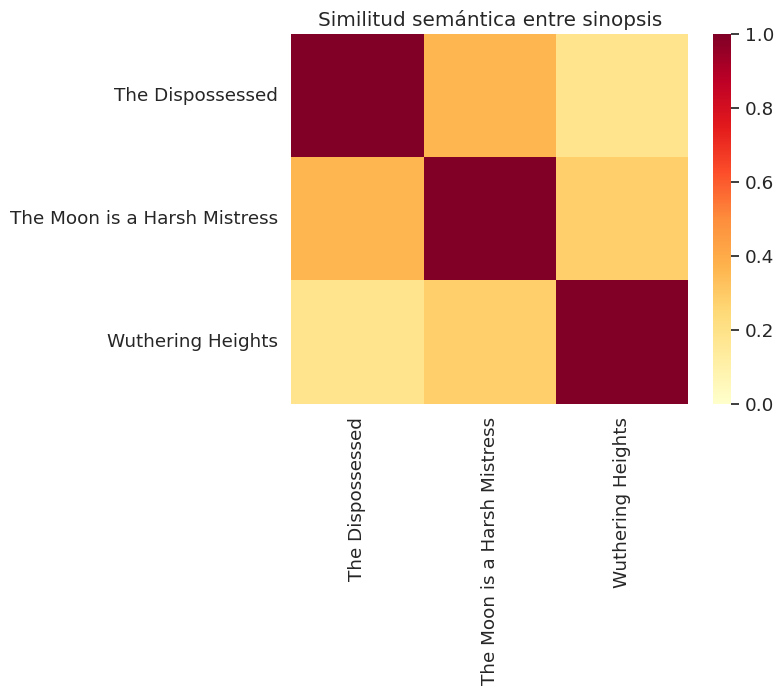

In [6]:
import seaborn as sns

def plot_similarity(features, labels, rotation, similarity):
    """
    Representa la similitud entre embeddings con un mapa de calor
    """
    corr = similarity(features, features)
    print(corr)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Similitud semántica entre sinopsis")

plot_similarity(encoded_book_summaries.detach().cpu(), titles, 90, util.cos_sim)

Libro: The Dispossessed
Tamaño del embedding: 384
Embedding: [-0.0634327232837677, 0.06581516563892365, -0.05767375975847244, ...]

Libro: The Moon is a Harsh Mistress
Tamaño del embedding: 384
Embedding: [-0.007722361944615841, 0.030132809653878212, 0.022305624559521675, ...]

Libro: Wuthering Heights
Tamaño del embedding: 384
Embedding: [-0.014147468842566013, 0.04263626039028168, 0.013696917332708836, ...]

tensor([[1.0000, 0.3470, 0.0815],
        [0.3470, 1.0000, 0.2711],
        [0.0815, 0.2711, 1.0000]])


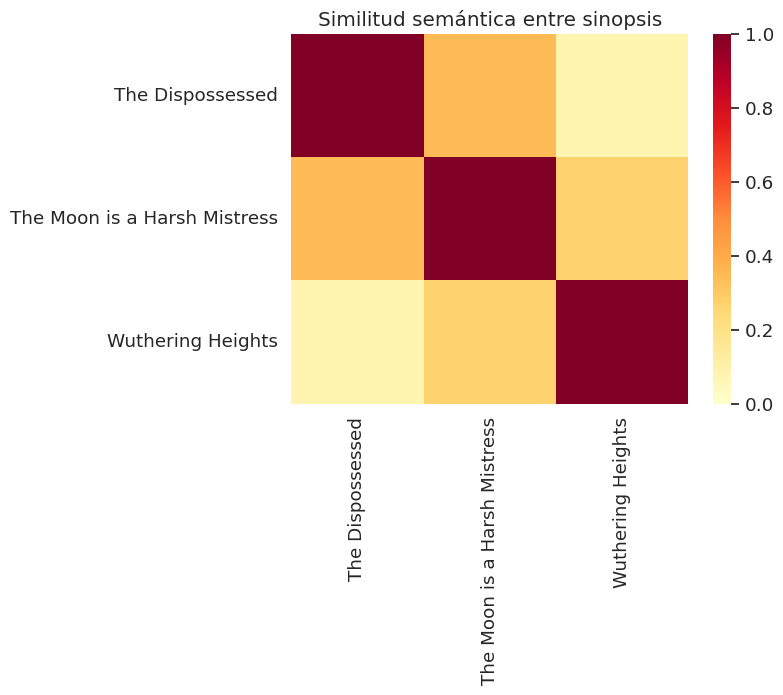

In [7]:
"""
Versión del anterior modelo menos potente, pero mucho más rápida
Embeddings de 384 dimensiones y normalizados
"""
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = bert_model.encode(book_summaries, convert_to_tensor=True)

# Representación de los embeddings
pretty_print_embeddings(encoded_book_summaries, titles)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries.detach().cpu(), titles, 90, util.dot_score)

En ambos casos el resultado es muy parecido. Hay más relación entre los libros de ciencia ficción que comparten temática utópica, que comparando ambos títulos con el libro de Emily Brontë. Sin embargo, al ser de tonos distintos los libros de ciencia ficción (y las sinopsis que se incluyen), no tienen una relación directa tan elevada, tal y como nos indica el valor de la similitud coseno, en torno a 0.35.

Libro: The Dispossessed
Tamaño del embedding: 768
Embedding: [-0.013097244314849377, -0.03979548439383507, -0.002570291282609105, ...]

Libro: The Moon is a Harsh Mistress
Tamaño del embedding: 768
Embedding: [-0.01247728243470192, -0.06656759977340698, 0.011771190911531448, ...]

Libro: Wuthering Heights
Tamaño del embedding: 768
Embedding: [-0.0031156023032963276, -0.057925812900066376, -0.007614106871187687, ...]

tensor([[1.0000, 0.4606, 0.3076],
        [0.4606, 1.0000, 0.4842],
        [0.3076, 0.4842, 1.0000]])


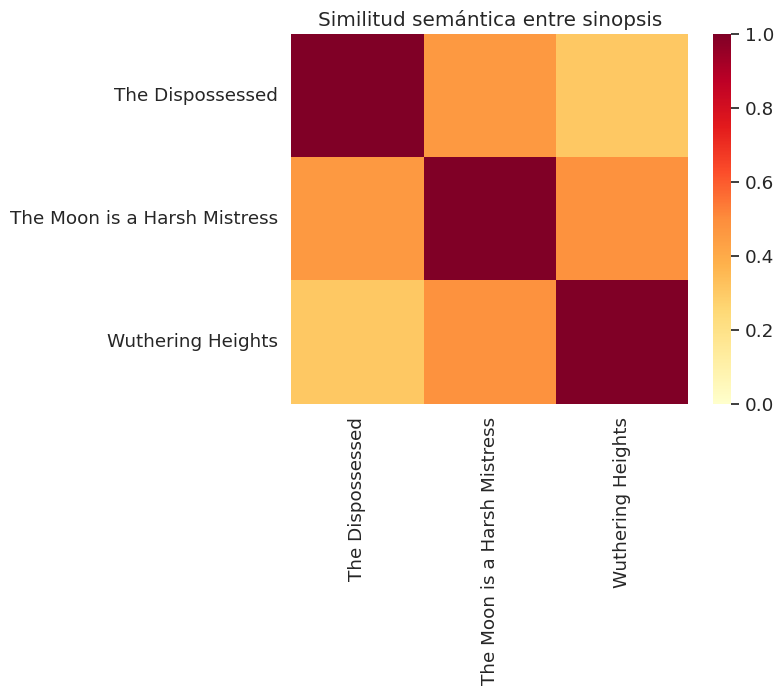

In [8]:
"""
Segundo modelo más potente
768 dimensiones, embeddings normalizados
"""
bert_model = SentenceTransformer('all-distilroberta-v1')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = bert_model.encode(book_summaries, convert_to_tensor=True)

# Representación de los embeddings
pretty_print_embeddings(encoded_book_summaries, titles)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries.detach().cpu(), titles, 90, util.dot_score)

Con este modelo, el resultado es algo sorprendente, pues encuentra mayor similitud entre *Harsh Mistress* y *Wuthering Heights*, a priori libros bastante dispares. Quizá el modelo no se adapta tan bien a lo que pretendemos detectar en cuanto a las sinopsis, o haya detectado en ellas una intencionalidad pasional, visceral que sí está presente en ambas novelas.

Libro: The Dispossessed
Tamaño del embedding: 768
Embedding: [0.026562461629509926, 0.06719020754098892, 0.0023890379816293716, ...]

Libro: The Moon is a Harsh Mistress
Tamaño del embedding: 768
Embedding: [0.047038447111845016, 0.05109722167253494, -0.0022063401993364096, ...]

Libro: Wuthering Heights
Tamaño del embedding: 768
Embedding: [-0.027124419808387756, -0.022673657163977623, 0.0072197881527245045, ...]

tensor([[1.0000, 0.4642, 0.1688],
        [0.4642, 1.0000, 0.3968],
        [0.1688, 0.3968, 1.0000]])


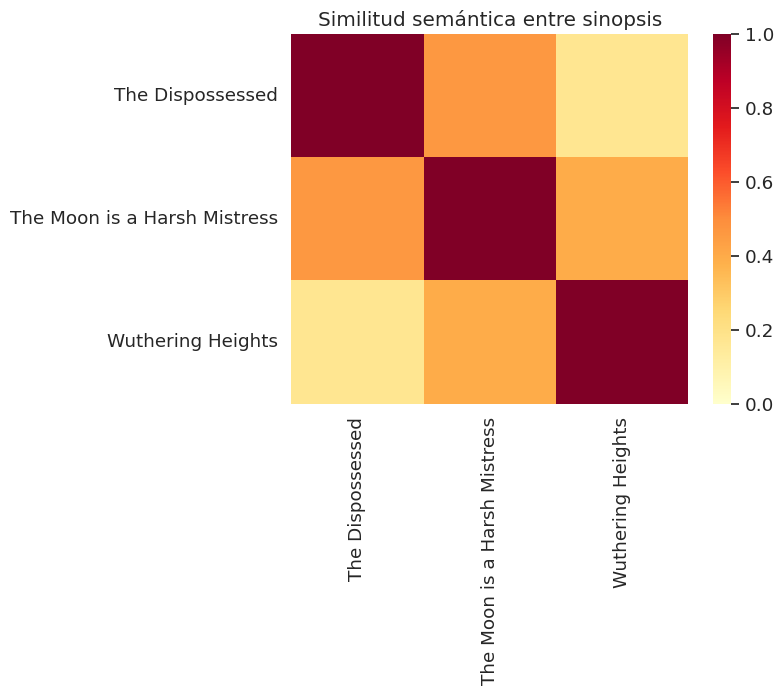

In [9]:
"""
Modelo más potente que actualmente ofrece sentence-transformers
768 dimensiones, embeddings normalizados
"""
bert_model = SentenceTransformer('all-mpnet-base-v2')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = bert_model.encode(book_summaries, convert_to_tensor=True)

# Representación de los embeddings
pretty_print_embeddings(encoded_book_summaries, titles)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries.detach().cpu(), titles, 90, util.dot_score)

En este último modelo, los resultados son algo más cercanos a lo esperado. Sin embargo, sigue habiendo poca discrepancia entre los dos títulos ya mencionados, de los que cabría esperar una diferencia algo marcada.

Así pues, de utilizar SBERT, quizá nos interesen el modelo `all-MiniLM-L6-v2`, más rápido, o el más potente de todos, el último analizado, `all-mpnet-base-v2`. Este último procede del modelo creado por *Microsoft*.

Un detalle importante es que SBERT también ofrece modelos multilingües pre-entrenados muy potentes, por lo que es posible realizar una comparación de textos en idiomas distintos. Esto nos puede servir por el hecho de que algunas de las sinopsis incluidas en el dataset de los libros están en diversos idiomas, no sólo inglés.

Otro modelo actual para comparación de texto es USE (*Universal Sentence Encoder*), de *Google*. Similar a BERT, actúa tanto sobre frases como piezas de texto enteras, transformándolos en *embeddings*. Veamos qué resultados nos aporta.

Libro: The Dispossessed
Tamaño del embedding: 512
Embedding: [0.025118932127952576, -0.02112305909395218, -0.04627455398440361, ...]

Libro: The Moon is a Harsh Mistress
Tamaño del embedding: 512
Embedding: [0.038793303072452545, -0.0281276386231184, -0.030823856592178345, ...]

Libro: Wuthering Heights
Tamaño del embedding: 512
Embedding: [0.004078531172126532, 0.016305899247527122, -0.06351318210363388, ...]

[[1.0000001  0.46380812 0.2114826 ]
 [0.46380812 1.         0.27910817]
 [0.2114826  0.27910817 1.0000001 ]]


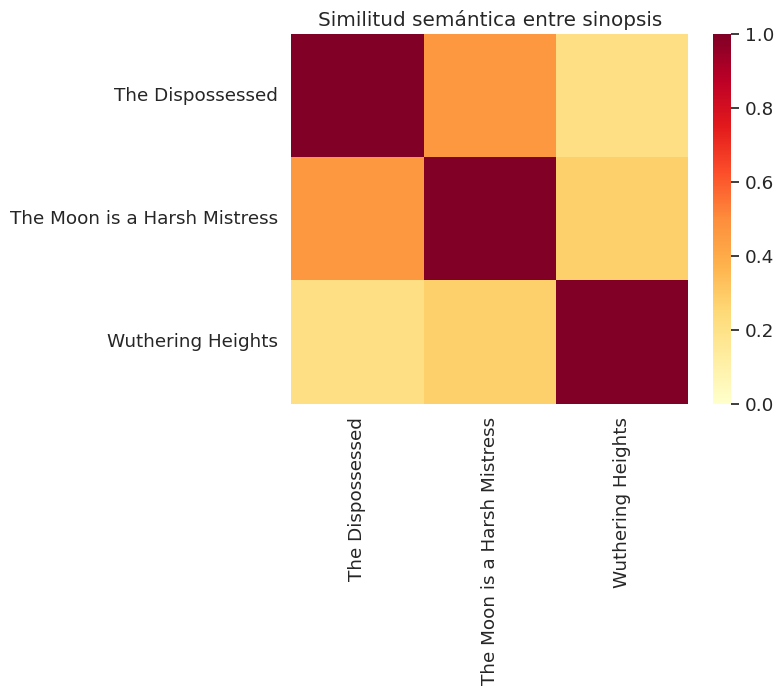

In [10]:
import tensorflow_hub as hub

# Cargamos el modelo de Universal Sentence Encoder
use_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = use_model(book_summaries)

# Representación de los embeddings
pretty_print_embeddings(encoded_book_summaries, titles)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries, titles, 90, np.inner)

Como vemos, el resultado del modelo de *Google* sí se acerca más a lo que cabríamos esperar. Cierta cercanía entre los títulos de ciencia ficción, mientras que hay una discrepancia más o menos clara cuando se hace la comparación con la novela de mediados del siglo XIX.

Por tanto, a la hora de convertir las sinopsis en vectores que capturan el sentido semántico, podemos optar por el modelo reducido, pero eficiente y preciso, `all-MiniLM-L6-v2`, que nos ofrece SBERT, así como el modelo USE de Google. Ambos aportan resultados muy razonables, además de proceder de técnicas más punteras sobre NLP.

### Sentiment analysis

En uno de los comentarios acerca del resultado de los modelos SBERT, mencionábamos cómo la visceralidad o la pasionalidad del lenguaje empleado en la sinopsis de *Wuthering Heights*, sentimiento muy presente en la trama de dicha novela, podría haber influido en arrojar una similitud a considerar con *Harsh Mistress*. Lo cierto es que su sinopsis comparte un tono similar, y ambos libros incluyen un sentimiento de conflicto, latente a lo largo de las novelas.

Con esto, nos referimos a que las expresiones o tonalidades del lenguaje, en este caso usadas en las sinopsis, pueden jugar un papel interesante a la hora de tomar preferencia por un libro u otro. No sólo el contenido o la trama capturados de forma semántica, sino que el tono y las emociones desplegadas en las sinopsis (pero muy posiblemente presentes también en los libros) son otros aspectos a tener en cuenta a la hora de transformarlas en *inputs* para nuestro posterior modelo del sistema de recomendación.

Así, podemos llevar a cabo un *Sentiment Analysis* de las sinopsis, como entrada alternativa al modelo recomendador. Utilizaremos de nuevo *Transformers*, pero esta vez un par de modelos disponibles para clasificación de texto (multi-label) que podemos encontrar en [HuggingFace](https://huggingface.co/).

In [11]:
from transformers import pipeline

classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

model_outputs = classifier(book_summaries)
for model_output in model_outputs:
    print(model_output) # Lista de diccionarios para cada una de las etiquetas

[{'label': 'neutral', 'score': 0.6230483055114746}, {'label': 'approval', 'score': 0.24587662518024445}, {'label': 'optimism', 'score': 0.06499189138412476}, {'label': 'admiration', 'score': 0.03109806589782238}, {'label': 'realization', 'score': 0.019836679100990295}, {'label': 'caring', 'score': 0.010265346616506577}, {'label': 'desire', 'score': 0.009951691143214703}, {'label': 'annoyance', 'score': 0.00799098052084446}, {'label': 'disapproval', 'score': 0.006215779110789299}, {'label': 'fear', 'score': 0.005300717893987894}, {'label': 'disappointment', 'score': 0.003377724438905716}, {'label': 'excitement', 'score': 0.0022787339985370636}, {'label': 'pride', 'score': 0.00204101181589067}, {'label': 'anger', 'score': 0.0017862499225884676}, {'label': 'sadness', 'score': 0.0016334335086867213}, {'label': 'disgust', 'score': 0.0014268066734075546}, {'label': 'confusion', 'score': 0.001279135700315237}, {'label': 'relief', 'score': 0.0012104834895581007}, {'label': 'curiosity', 'score'

In [12]:
classifier = pipeline(task="text-classification", model="bdotloh/distilbert-base-uncased-empathetic-dialogues-context", top_k=None)

model_outputs = classifier(book_summaries)
for model_output in model_outputs:
    print(model_output) # Lista de diccionarios para cada una de las etiquetas

[{'label': 'devastated', 'score': 0.9129787087440491}, {'label': 'terrified', 'score': 0.7744700908660889}, {'label': 'confident', 'score': 0.535319447517395}, {'label': 'trusting', 'score': 0.4991433918476105}, {'label': 'afraid', 'score': 0.498222678899765}, {'label': 'apprehensive', 'score': 0.4695793092250824}, {'label': 'prepared', 'score': 0.4523140490055084}, {'label': 'faithful', 'score': 0.4400794506072998}, {'label': 'furious', 'score': 0.4066949784755707}, {'label': 'surprised', 'score': 0.39816588163375854}, {'label': 'anticipating', 'score': 0.3504151403903961}, {'label': 'hopeful', 'score': 0.3330118656158447}, {'label': 'anxious', 'score': 0.31251218914985657}, {'label': 'impressed', 'score': 0.24288120865821838}, {'label': 'excited', 'score': 0.2202327400445938}, {'label': 'angry', 'score': 0.1810828298330307}, {'label': 'proud', 'score': 0.13176749646663666}, {'label': 'joyful', 'score': 0.12579019367694855}, {'label': 'sad', 'score': 0.12336388230323792}, {'label': 'd

### TF-IDF (Term Frequency-Inverse Document Frequency)